# Bandit Assignment

This assignment should be done in groups of 2 or 3 and consists of a number of implementation and theory problems based on the topics discussed in the lectures and the course literature (specifically, **version 5** on arXiv):

[Bandits] *Aleksandrs Slivkins, [Introduction to Multi-Armed Bandits](https://arxiv.org/pdf/1904.07272v5.pdf), Found. Trends Mach. Learn. 12(1-2): 1-286 (2019)*

In the implementation problems **(1, 2, 3 and 5)**, you will implement multi-armed bandit algorithms from the [Bandits] book and use them in a provided multi-armed bandit environment. These problems will be graded based on the correctness of the code. You are only required to implement 3 out of 4 of these algorithms and will receive at most 6 points from the implementations. Points may be deducted for incorrect implementation of the 4th algorithm.

In the theory problems **(4 and 6)**, you will derive some properties of the algorithms. These problems will be graded based on the correctness of the arguments.

In the applied problem **(7)**, you will apply the implemented algorithms or another algorithm of your choosing to a bandit problem with irregular real-world data. This problem will be graded based on your algorithm's performance relative to a set of baselines. This problem likely requires you to revise your previously implemented algorithms or implement new algorithms.

You may use the python libraries imported below (*numpy*, *scipy.stats* and *pandas*).

The assignment should be handed in as an updated notebook. The entire notebook should be run before it is handed in, so that the plots are visible. Ensure that it is completely runnable, in the case that we want to reproduce the results. 

## Setup

The cell below contains imports. It may not be modified!

In [1]:
# DO NOT MODIFY
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pickle

SEED = 150
ITERATIONS = 20
K = 100
K_CROPS = 3
T = 10000

The cell below contains the bandit environment and may not be modified!

In [2]:
# DO NOT MODIFY
class Environment:
    def __init__(self, K: int=10, seed: int=0):
        self.random_state = np.random.RandomState(seed=seed)
        self.mu = st.beta.rvs(a=1, b=1, size=K, random_state=self.random_state)
        
    def expected_value(self, a: int) -> float:
        return self.mu[a]
        
    def perform_action(self, a: int) -> int:
        return st.bernoulli.rvs(self.mu[a], random_state=self.random_state)
        
    def optimal_action(self) -> np.intp:
        return np.argmax(self.mu)

class CropEnvironment(Environment):
    def __init__(self, seed: int = 0):
        with open('samples_small.pkl', 'rb') as f:
            samples: np.ndarray = pickle.load(f)
        self.K = samples.shape[0]
        self.N = samples.shape[1]
        samples = samples / samples.max()
        self.random_state = np.random.default_rng(seed=seed)
        self.shuffled_samples = self.random_state.permutation(samples, axis = 0)
        self.mu = np.mean(self.shuffled_samples, axis = 1)

    def expected_value(self, a: int) -> float:
        return self.mu[a]
        
    def perform_action(self, a: int) -> float:
        i = self.random_state.integers(0, self.N)
        return self.shuffled_samples[a,i]
        
    def optimal_action(self) -> int:
        return np.argmax(self.mu)

The cell below contains the bandit algorithm base class and may not be modified!

In [3]:
# DO NOT MODIFY
class BanditAlgorithmBase:
    def select_action(self) -> int:
        pass
    
    def update(self, action: int, reward: float):
        pass

The cell below contains the bandit experiment and may not be modified!

In [4]:
# DO NOT MODIFY
class Experiment:
    def __init__(self, environment, bandit_algorithm):
        self.environment = environment
        self.bandit_algorithm = bandit_algorithm
        
    def run_experiment(self, T=100):
        instant_regrets = np.zeros(T)
        for t in range(0, T):
            action = self.bandit_algorithm.select_action()
            reward = self.environment.perform_action(action)
            self.bandit_algorithm.update(action, reward)
            
            optimal_action = self.environment.optimal_action()
            instant_regret = self.environment.expected_value(optimal_action) - self.environment.expected_value(action)
            instant_regrets[t] = instant_regret
        cumulative_regrets = np.cumsum(instant_regrets)
        return (instant_regrets, cumulative_regrets)

The cell below contains a function for repeated experiments with a provided bandit algorithm, averaging regret over the runs. It may not be modified!

In [5]:
# DO NOT MODIFY
def run_repeated_experiments(bandit_algorithm_class: BanditAlgorithmBase, T: int,  K: int, seed: int, env_class: type = Environment):
    instant_regrets = []
    cumulative_regrets = []
    if env_class == Environment:
        env_constructor = lambda seed: Environment(K, seed)
    elif env_class == CropEnvironment:
        env_constructor = lambda seed: CropEnvironment(seed)
    else:
        raise ValueError(f"Argument env_class must be either 'Environment' or 'CropEnvironment', but got {env_class}.")
    for i in range(ITERATIONS):
        bandit_algorithm = bandit_algorithm_class(T, K)
        environment = env_constructor(seed+i+1)
        experiment = Experiment(environment, bandit_algorithm)

        instant_regrets_i, cumulative_regrets_i = experiment.run_experiment(T)
        instant_regrets.append(instant_regrets_i)
        cumulative_regrets.append(cumulative_regrets_i)
    return pd.DataFrame(data={'t': np.arange(1, T+1),
                             'instant_regret': np.mean(np.vstack(np.array(instant_regrets)), axis=0),
                             'regret': np.mean(np.vstack(np.array(cumulative_regrets)), axis=0)})


## Stochastic Bandits (Chapter 1)

### Problem 1: Implement Explore-First
(2 points, at most 6 points from implementations)

Implement the *Explore-First* algorithm (**Algorithm 1.1** in [Bandits]) within the provided bandit algorithm template below. Use $N = \left(\frac{T}{K}\right)^{2/3} \cdot \left( \log T \right)^{1/3}$.

In [14]:
class ExploreFirst(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        self.N = int((T / K) ** (2/3) * (np.log(T)) ** (1/3))
        # Numbers of times that every action has been tried
        self.tried_counts = np.zeros(K)
        # Total rewards for every action
        self.total_rewards = np.zeros(K)
        # Average rewards for every action
        self.avg_rewards = np.zeros(K)
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        # Actions that are tried < N times
        actions_to_try = [i for i in range(self.K) if self.tried_counts[i] < self.N]
        # If there is action tried < N times, continue exploration
        if len(actions_to_try) > 0:
            return np.random.choice(actions_to_try)
        # Else, start exploitation using the arm with highest average reward
        else:
            return np.argmax(self.avg_rewards)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.tried_counts[action] += 1
        self.total_rewards[action] += reward
        self.avg_rewards[action] = self.total_rewards[action] / self.tried_counts[action]

Run the algorithm in the provided environment using the code below (averaging the regret over all runs). The exploration and exploitation phases should be clearly visible in the plot.

<Axes: title={'center': 'Explore-First'}, xlabel='t'>

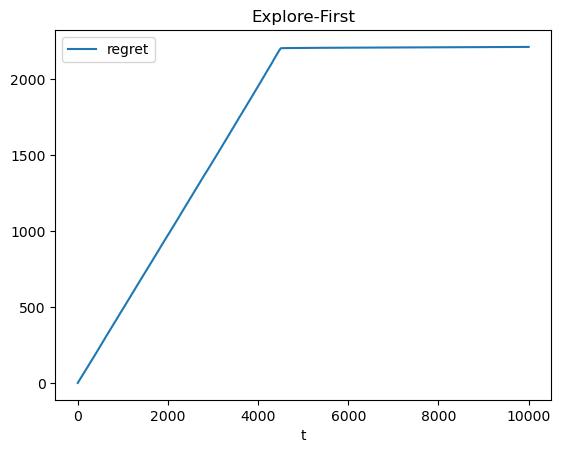

In [15]:
# DO NOT MODIFY
np.random.seed(SEED)
ef_df = run_repeated_experiments(ExploreFirst, T, K, SEED)
ef_df.plot(x='t', y='regret', title='Explore-First')

### Problem 2: Implement Epsilon-Greedy
(2 points, at most 6 points from implementations)

Implement the $ \epsilon_t $-*Greedy* algorithm (**Algorithm 1.2** in [Bandits]) within the provided bandit algorithm template below. Use $\epsilon_t = \min \left\{1,\ t^{-1/3} \cdot (K \log t)^{1/3}\right\} $.

In [53]:
class EpsilonTGreedy(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        # Current round count
        self.t = 1
        # Numbers of times that every action has been tried
        self.tried_counts = np.zeros(K)
        # Total rewards for every action
        self.total_rewards = np.zeros(K)
        # Average rewards for every action
        self.avg_rewards = np.zeros(K)
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        epsilon_t = min(1, (self.t ** (-1/3)) * (self.K*np.log(self.t)) ** (1/3))
        # Toss the coin:
        if (np.random.rand() < epsilon_t):
            # Exploration
            return np.random.randint(0, self.K)
        else:
            # Exploitation
            return np.argmax(self.avg_rewards)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.t += 1
        self.tried_counts[action] += 1
        self.total_rewards[action] += reward
        self.avg_rewards[action] = self.total_rewards[action] / self.tried_counts[action]

Run the algorithm in the provided environment using the code below (averaging the regret over all runs). The plot should show sublinear regret with respect to $t$.

<Axes: title={'center': 'Epsilon_t-Greedy'}, xlabel='t'>

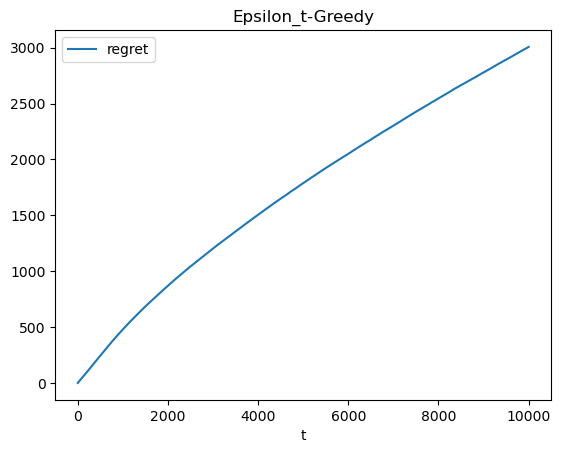

In [17]:
# DO NOT MODIFY
np.random.seed(SEED)
eg_df = run_repeated_experiments(EpsilonTGreedy, T, K, SEED)
eg_df.plot(x='t', y='regret', title='Epsilon_t-Greedy')

### Problem 3: Implement UCB1
(2 points, at most 6 points from implementations)

Implement the UCB1 algorithm (**Algorithm 1.5** in [Bandits]) within the provided bandit algorithm template below.

In [6]:
class UCB1(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        # Current round count
        self.t = 1
        # Numbers of times that every action has been tried
        self.tried_counts = np.zeros(K)
        # Total rewards for every action
        self.total_rewards = np.zeros(K)
        # Average rewards for every action
        self.avg_rewards = np.zeros(K)
        # UCBs
        self.UCB = np.zeros(K)
        
        
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        # Try each arm once
        if (self.t <= self.K):
            return self.t - 1
        else:
            # Exploitation
            return np.argmax(self.UCB)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.t += 1
        self.tried_counts[action] += 1
        self.total_rewards[action] += reward
        self.avg_rewards[action] = self.total_rewards[action] / self.tried_counts[action]
        
        confidence_radius = np.sqrt((2 * np.log(self.T)) / self.tried_counts[action])
        self.UCB[action] = self.avg_rewards[action] + confidence_radius

Run the algorithm in the provided environment using the code below (averaging the regret over all runs). The plot should show sublinear regret with respect to $t$.

<Axes: title={'center': 'UCB1'}, xlabel='t'>

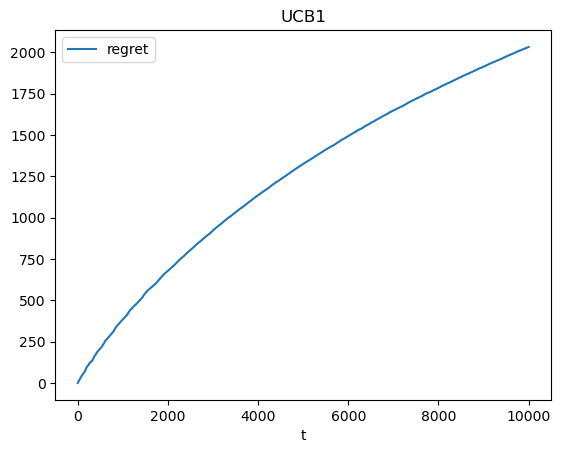

In [19]:
# DO NOT MODIFY
np.random.seed(SEED)
ucb1_df = run_repeated_experiments(UCB1, T, K, SEED)
ucb1_df.plot(x='t', y='regret', title='UCB1')

### Problem 4: Regret for modified UCB1
(6 points) 

This theory problem is based on **Exercise 1.1** in [Bandits]. The proofs in **Chapter 1** consider environments where the rewards are in the interval $[0,1]$. Consider the case when we have additional knowledge about about the problem and that we know that the rewards for each action are in the interval $\left[\frac{1}{2}, \frac{1}{2} + \epsilon\right]$ for some fixed $\epsilon \in \left(0, \frac{1}{2}\right)$. 

Consider a version of $\text{UCB1}$ modified to utilize this knowledge (you do not need to specify the algorithm completely, just define the new confidence radius $r_t(a)$). For this algorithm and problem setting, prove that:

$\mathbb{E}\left[R(t)\right] \leq \frac{2 \epsilon t}{T^2} + 2 \epsilon \sqrt{2 K t \log T}$

**Instructions:** Use a version of Hoeffding Inequality with ranges (**Theorem A.2** in the [Bandits] book) to modify the confidence radius $r_t(a)$. Subsequently follow the steps of the analysis leading up to **Theorem 1.14** in [Bandits] to derive the regret bound, though show the actual constants instead of using big O notation:

1. Define the clean event, like in **Section 1.3.1**, and lower bound the probability of the event.
2. Start with the definition of the regret $\mathbb{E}\left[R(t)\right]$, and perform a regret decomposition like on **Page 11** of **Section 1.3.2**.
3. Bound the *gap* $\Delta (a_t)$, like in **Section 1.3.3**.
4. Complete the proof using the technique on **Page 12** of **Section 1.3.2**. Note that applying the bound in step 3 requires careful motivation.

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

### Step 1. Hoeffding Inequality and Confidence Radius
According to **Theorem A.2(a)** in the book, we have:
$$
\beta = \frac{1}{n} \sum_{i \in [n]} (b_i - a_i)^2 = \frac{1}{n} \sum_{i \in [n]} \epsilon^2 = \epsilon^2
$$
According to **Equation (A.1)/(A.2)**, let $\alpha = 2$ as recommended in the book, we have:
$$
\Pr (|\bar{\mu}_t(a) - \mu(a)| \le r_t(a)) \ge 1 - 2 \cdot T^{-4}
$$
where:
$$
r_t(a) = \sqrt{\frac{\alpha \beta \log{T}}{n_t(a)}} = \sqrt{\frac{2 \epsilon^2 \log{T}}{n_t(a)}}
$$

### Step 2. Clean Event and its Probability Lower Bound
According to the Hoeffding Inequality mentioned in step 1:
$$
\exists t \quad \Pr (|\bar{\mu}_t(a) - \mu(a)| \gt r_t(a)) \le \frac{2}{T^4}
$$
Thus, taking a union bound:
$$
\Pr (\exists t \quad |\bar{\mu}_t(a) - \mu(a)| \gt r_t(a)) \le \sum_{t=1}^T \frac{2}{T^4} = \frac{2}{T^3} 
$$
For all arms simultaneously, assuming that $K \le T$, where $K$ is the number of arms:
$$
\Pr (\exists t \exists a \quad |\bar{\mu}_t(a) - \mu(a)| \gt r_t(a)) \le \sum_{k=1}^K \frac{2}{T^3} \le \frac{2}{T^2} 
$$
Define clean event as $\varepsilon := \{\forall t \forall a \quad |\bar{\mu}_t(a) - \mu(a)| \le r_t(a)\}$, we have:
$$
\Pr(\varepsilon) = 1 - \Pr(\neg \varepsilon) \ge 1 - \frac{2}{T^2}
$$

### Step 3. Bounding Regret
According to **section 1.3.2**, we have:
$$
\mathbb{E}[R(t)] = \mathbb{E}[R(t)\mid \varepsilon] \cdot \Pr[\varepsilon] + \mathbb{E}[R(t)\mid \neg\varepsilon] \cdot \Pr[\neg\varepsilon]
$$
Where $\varepsilon$ notates the clean event

First we can get the upper bound for the regret from bad events. Since the max instant regret for a single action is $\frac{1}{2} + \epsilon - \frac{1}{2} = \epsilon$, and thus the max accumulated regret for $t$ rounds is $\epsilon \cdot t$. Thus:
$$
\mathbb{E}[R(t)] \le \mathbb{E}[R(t)\mid \varepsilon] \cdot \Pr[\varepsilon] + \epsilon \cdot t \cdot \frac{2}{T^2} \qquad (\text{Ineq. a})
$$
Secondly we consider about clean events. For any single round that we choose a non-optimal arm $a$ that has a lower expected reward than the optimal arm $a^*$, the instant regret can be bounded.

According to **(1.12),(1.13) in Section 1.3.3**:
$$
\mu(a_t) + 2r_t(a_t) \ge \bar{\mu}_t(a_t) + r_t(a_t) = \mathrm{UCB}_t(a_t) \ge \mathrm{UCB}_t(a^*) \ge \mu(a^*).
$$
It follows that:
$$
\Delta(a_t) := \mu(a^*) - \mu(a_t) 
\le 2r_t(a_t) 
= 2 \sqrt{\tfrac{2 \epsilon^2 \log T}{n_t(a_t)}}.
$$
Define $R(t;a)$ as the regret contribution of arm $a$ in the first $t$ rounds, we have:
$$
R(t;a) = n_t(a) \cdot \Delta(a) \le n_t(a) \cdot 2 \sqrt{\tfrac{2 \epsilon^2 \log T}{n_t(a_t)}} = 2\sqrt{2 \epsilon^2 \cdot n_t(a) \cdot \log T} 
$$
Define $A$ as the set includes all arms, and $A^+ = \{a:\mu(a) < \mu(a^*)\}$ as the set includes all arms that contribute to regret. We have accumulated regret until round $t$ from all arms:
$$
R(t) = \sum_{a \in A^+}R(t;a) \le \sum_{a \in A} 2\sqrt{2 \epsilon^2 \cdot n_t(a) \cdot \log T} = 2\sqrt{2 \epsilon^2  \cdot \log T} \cdot \sum_{a \in A} \sqrt{n_t(a)}
$$
Note that $|A| = K$, and $f(x) = \sqrt{x}$ is convex. According to Jensen Inequality:
$$
\frac{1}{K} \cdot \sum_{a \in A} \sqrt{n_t(a)} \leq \sqrt{ \left( \frac{1}{K} \sum_{a \in A} n_t(a) \right) } = \sqrt{ \frac{t}{K} } \quad \Rightarrow \sum_{a \in A} \sqrt{n_t(a)} \leq \sqrt{t \cdot K}
$$
Therefore:
$$
R(t) \le 2\sqrt{2 \epsilon^2  \cdot \log T} \cdot \sum_{a \in A} \sqrt{n_t(a)}
\le 2\sqrt{2 \epsilon^2  \cdot \log T \cdot t \cdot K}
$$
Finally, we can say that the upper bound for the expected regret in clean event scenarios is:
$$
\mathbb{E}[R(t)\mid \varepsilon] \le 2\epsilon\sqrt{2Kt \log T}
$$
Plug this inequality in *Ineq. a* mentioned above, we have:
$$
\mathbb{E}[R(t)] \le \mathbb{E}[R(t)\mid \varepsilon] \cdot \Pr[\varepsilon] + \epsilon \cdot t \cdot \frac{2}{T^2} \le 2\epsilon\sqrt{2Kt \log T} \cdot 1 +\epsilon \cdot t \cdot \frac{2}{T^2} 
$$
Finally, we have:
$$
\mathbb{E}[R(t)] \le 2\epsilon\sqrt{2Kt \log T} +\frac{2\epsilon t}{T^2} 
$$

## Bayesian Bandits (Chapter 3)

### Problem 5: Implement Thompson Sampling
(2 points, at most 6 points from implementations)

Implement the *Thompson Sampling* algorithm (**Algorithm 3.3** in [Bandits]) within the provided bandit algorithm template below. Assume independent priors and that the prior is $\mathbb{P} = \text{Beta}(\alpha_0, \beta_0)$ with $\alpha_0 = 1$ and $\beta_0 = 1$ (i.e. the **Beta-Bernoulli** setting, on **page 35** in [Bandits]).

**Note:** There is a typo in the expression for the posterior $\mathbb{P}_H$ in [Bandits]. It should be $\text{Beta}(\alpha_0 + \text{REW}_H,\ \beta_0 + t - \text{REW}_H)$.

In [7]:
class ThompsonSampling(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        # Current round count
        self.t = 1 
        self.tried_counts = np.zeros(K)
        self.total_rewards = np.zeros(K)
        self.alpha = np.ones(K)
        self.beta = np.ones(K)

    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        # Sample from the Beta Distribution with parameters alpha/beta
        samples = np.random.beta(self.alpha, self.beta)  
        return np.argmax(samples) 

    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.t += 1
        self.tried_counts[action] += 1
        self.total_rewards[action] += reward
        if reward == 1:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

Run the algorithm in the provided environment using the code below (averaging the regret over all runs). The plot should show sublinear regret with respect to $t$.

<Axes: title={'center': 'Thompson Sampling'}, xlabel='t'>

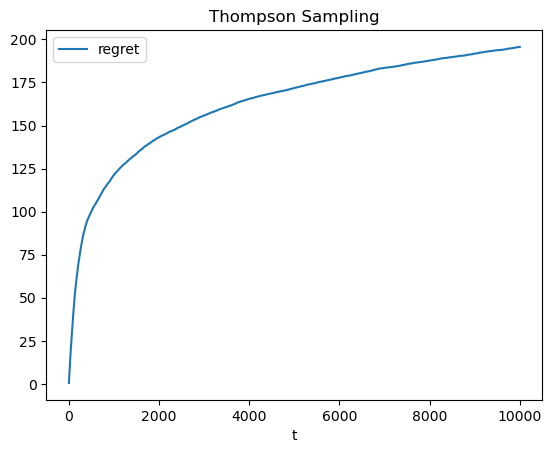

In [21]:
# DO NOT MODIFY
np.random.seed(SEED)
ts_df = run_repeated_experiments(ThompsonSampling, T, K, SEED)
ts_df.plot(x='t', y='regret', title='Thompson Sampling')

### Problem 6: Regret for Thompson Sampling
(6 points)

In this theory problem, you will show an intermediary step in the proof for the Bayesian regret bound of *Thompson Sampling* in the [Bandits] book.

You are given a $K$-armed bandit problem with rewards in the interval $[0, 1]$. You can assume that $K \leq T$, where $T$ is the horizon. Additionally, you can assume that **Lemma 1.5** holds (i.e., for this assignment we define $r_t (a) := \sqrt{\frac{2  \log T}{ n_t (a)}}$, and then it holds that $\text{Pr}\left\{ \mathcal{E} \right\} \geq 1 - \frac{2}{T^2}$ with $\mathcal{E} := \left\{ \forall a \forall t \;\; \vert \bar{\mu}_t (a) - \mu (a) \vert \leq r_t (a) \right\}$). Then, with $\text{UCB}_t (a) := \bar{\mu}_t (a) + r_t (a)$, show that $\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \leq \frac{2}{TK}$ (i.e., show that Equation 3.14 in [Bandits], with $\gamma = 2$, holds for all arms $a$ and rounds $t$).

**Note:** $[x]^{-}$ is the negative portion of $x$, i.e., $[x]^{-} = 0$ if $x \geq 0$ and $[x]^{-} = \vert x \vert$ otherwise.

**Hint:** Remember that, given a random variable $X$, an event $\mathcal{E}$ (subset of the sample space) and its complement $\mathcal{E}^c$, by the tower rule, $\mathbb{E}\left[ X \right] = \mathbb{E}\left[ X \;\vert\; \mathcal{E} \right] \cdot \text{Pr}\left\{ \mathcal{E} \right\} + \mathbb{E}\left[ X \;\vert\; \mathcal{E}^c \right] \cdot \text{Pr}\left\{ \mathcal{E}^c \right\}$.

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

According to the tower rule:

$$
\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] = 
\Pr(\text{UCB}_t (a) - \mu (a) \lt 0) \cdot \mathbb{E}[\text{UCB}_t (a) - \mu (a) | \text{UCB}_t (a) - \mu (a) \lt 0] + 0 \cdot \Pr(\text{UCB}_t (a) - \mu (a) \ge 0)
\\
= \Pr(\text{UCB}_t (a) \lt \mu (a)) \cdot \mathbb{E}[\text{UCB}_t (a) - \mu (a) | \text{UCB}_t (a) \lt \mu (a)]
$$
Since all rewards are bounded in $[0,1]$, the biggest absolute difference between 2 rewards is $1$. Thus we have $\mathbb{E}[\text{UCB}_t (a) - \mu (a) | \text{UCB}_t (a) - \mu (a) \lt 0] \le 1$, and therefore:
$$
\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \le 1 \cdot \Pr(\text{UCB}_t (a) \lt \mu (a))
$$
Clearly the event $\varepsilon_0 := \{\exist a \exist t \quad \text{UCB}_t (a) \lt \mu (a)\}$ is a **subset** of the bad event $\varepsilon^c$, and plus we have $K \le T$, therefore:
$$
\Pr(\varepsilon_0) \le \Pr(\varepsilon^c) \le \frac{2}{T^2} \le \frac{2}{TK} 
$$
Thus:
$$
\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \le \frac{2}{TK}
$$

## Overall comparison
The cell below plots the regret for all algorithms. Make sure to comment out the any algorithms you have not implemented. 

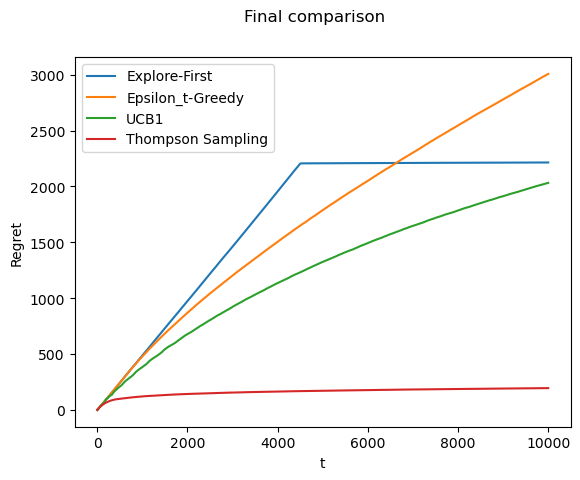

In [22]:
fig, ax = plt.subplots(1,1)
fig.suptitle("Final comparison")
ax.set_xlabel("t"); ax.set_ylabel("Regret")
dfs = [ # Comment out any algorithm that you have not implemented.
    (ef_df, "Explore-First"), 
    (eg_df, "Epsilon_t-Greedy"), 
    (ucb1_df, "UCB1"), 
    (ts_df, "Thompson Sampling")
]
for df, label in dfs: df.plot(x='t', y='regret',ax = ax, label = label) 

## Problem 7: Multi-armed bandits for optimizing crop yields

(6 points)

We consider the problem of selecting a date for planting maize grains as a multi-armed bandit problem. Year-to-year crop yields can vary heavily and depend on soil quality, genetics, the weather and other factors. We wish to identify the best date to plant maize among 7 dates. To help us, we will use data from a detailed simulator that generates realistic crop yields.

You have been given samples from $K = 3$ dates to experiment with locally in `samples.pkl`. The crop yields have been rescaled to lie in $[0,1]$ but the distributions do not fit most parametric models, see the histogram of one of the arms below.

![hist](sample_histogram.png?1)

When you submit this notebook to Canvas, your solution will be automatically evaluated on the full dataset of 7 dates. If the evaluation successfully ran, you will receive a comment in Canvas indicating your average total regret. If the evaluation failed to run, you should hopefully receive an error message on your submission. If you do not receive an error message or do not understand the error message, feel to reach out to the responsible TA or visit the consultation sessions. Your submission will be evaluated on 100 runs and must finish under 15 minutes. If your submission exceeds the time limit, you will likely not receive a comment.

The best result for each group will be tracked and uploaded to a [scoreboard on Canvas](https://chalmers.instructure.com/courses/35974/pages/scoreboard) where you will also see the three baselines that you must beat to earn points on this assignment. **Each baseline that you beat yields 2 points, up to a total of 6 points.** In addition, you must describe the process of solving this problem. Your description could include: the algorithms you attempted initially, why you think they worked poorly for this problem, what you tried to improve your algorithm (regardless of success) and a description of the final submission. Descriptions of low quality may reduce your points on this problem.

In order to evaluate your submission, one cell in the notebook must contain the string `SUBMISSION ALGORITHM` on the **first line** and must contain a class declaration that creates a subclass of `BanditAlgorithmBase`, see the example of RandomPolicy below.
**Important to note:** Your class *must not* depend on any external or global variables not provided to it, e.g. the line `self.K = K_CROPS` in `__init__` is not allowed but `self.K = K` is since `K` is a local variable. Similarly, your class *must only* depend on the Python packages provided in the setup cell (changing the setup cell does not affect our evaluation script).

**Hint:** Consider the information you are given about the reward distribution and the assumptions each algorithm assumes of the reward distributions. Which algorithm's assumptions most closely matches (or differs the most from) the information given about the reward distribution?

**Hint:** Some of the algorithms implemented in the previous problems contain hyperparameters that can be tuned to improve performance. Your solutions to previous problems must still match the descriptions in [Bandits]. If you do optimize the hyperparameters, implement a new class below.

**Hint:** The multi-armed bandit literature has plenty of algorithms that could be of interest here, see for example the book by [Lattimore](https://tor-lattimore.com/downloads/book/book.pdf), Successive Elimination (Algorithm 1.4 in [Bandits]), [RandUCB](https://arxiv.org/pdf/1910.04928), [KL-UCB](https://arxiv.org/pdf/1102.2490), Thompson sampling with Gaussian priors, [Feel-Good Thompson sampling](https://arxiv.org/pdf/2110.00871).

### Description of your process and final solution

### 1. Final Solution:

Our final solutions is `KL-UCB` with `Gaussian` KL-divergence. For hyper-parameters, the estimated reward standard deviation is set as `sigma=0.1`, and the exploration parameter is set as `c=2`

The reason why we chose it will be stated below.

### 2. Exploration:
#### 2.1 Basic algorithms described above
First of all, we tried some of the aforementioned algorithms. The rough results are as follows:

| Algorithm | validation regret T=10k|
|--------|------|
| explore first | 25 | 
| ε_t_greedy | 50 |
|UCB1 | 100 | 
|successive elimination|175|

Explore first algorithms seems good, but the test result is 68.49 average regret at T=10k, which barely passes the baseline.

#### 2.2 Thompson sampling variations
For Thompson sampling, we need to set proper prior distribution to make it work. If we ignore the peak at regret=0, the histogram looks like a skewed Gaussian distribution, or a long-tail distribution. The rough validation results are as follows:

| Algorithm | validation regret T=10k| Note |
|--------|------|-|
| Thompson Long-tailed | 40 ||
| Feel-Good Thompson Sampling | 50 | optimism = 0.01 |
| Thompson Gaussian | 12-45 |mu 0.35 tau 0.01-0.5 sigma 0.01-0.15|

In those trials, only the gaussian prior works well enough. However, the standard deviation `tau` is very tricky. When it is around 0.01, which is much smaller than our estimation 0.3-0.5 based on the histogram, it performs extremely well (regret around 12). However, the test result is very bad.

| Algorithm | Test score |Note|
|-|-|-|
| Thompson Gaussian | 60.40 |mu 0.35 tau 0.01 sigma 0.01|

This actually makes sense. When `tau` is set very small, we assume that the variance of rewards is small, thus the algorithm will quickly finish the exploration phase and start exploiting in a hurry. This may work well in a small dataset, but fails in a larger one, since the algorithm is more likely to quickly select a non-optimal arm and the long-term regret will increase due to the rush.

So far, Thompson Sampling with Gaussian prior can only perform well enough on the small dataset by extremely radical exploitation, and given that setup, the test result is unacceptable. Therefore, we give up on this algorithm.
#### 2.3 KL-UCB variations

KL-UCB seems feasible, since it has tighter upper bounds than UCB with Hoeffding bounds. 

Based on the experiment above, we think Gaussian distribution is a good choice to estimate the reward distribution, thus we choose Gaussian KL-divergence. The validation results are as follows:

| sigma | c | validation regret |
|-|-|-|
| 0.3 | 3 | 50+ |
| 0.01 | 3 | 50+ |
| 0.05 | 3 | 30+ |
| 0.15 | 3 | 25+ |
| 0.1 | 3 | 17.5 | 


As we can see, the best sigma is about 0.1, which aligns with our expectation. Now we want to fine-tune the exploration parameter which controls the preference on exploration and exploitation.

| sigma | c | validation regret |
|-|-|-|
| 0.1 | 3 | 17.5 | 
| 0.1 |4| 20 | 
| 0.1 |2| 14 | 

c = 3 and c = 2 both seem good! The test result is:
| sigma | c | test result |
|-|-|-|
|0.1|3| 42.53|
|0.1|2|38.58 |

Therefore, our final solution is KL-UCB with Gaussian KL-divergence, where estimated standard deviation `sigma=0.1` and exploration parameter `c=2`.

In [68]:
# SUBMISSION ALGORITHM

class KL_UCB(BanditAlgorithmBase): # Feel free to update the name of the policy to better describe your solution.

    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.K = K
        self.T = T
        # Current round count
        self.t = 1 
        self.tried_counts = np.zeros(K)
        self.total_rewards = np.zeros(K) 
        self.c = 2 # exploration parameter
        self.sigma = 0.1 # estimated standard deviation
    
    def kl_div(self, mean, q, dist="gaussian", sigma=0.1):
        if dist == "gaussian":
            return (mean - q)**2 / (2 * sigma**2)

    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        t = self.t
        # Exploration: every arm should be tried at least once
        for i in range(self.K):
            if self.tried_counts[i] == 0:
                return i

        UCB = np.zeros(self.K) 
        for i in range(self.K):
            mean = self.total_rewards[i] / self.tried_counts[i]
            rhs = (np.log(t) + self.c * np.log(np.log(t+1))) / self.tried_counts[i]
            # Binary search KL upper bound
            low, high = mean, 1
            for _ in range(8): 
                mid = (low + high) / 2
                if self.kl_div(mean, mid, dist="gaussian", sigma=self.sigma) <= rhs:
                    low = mid
                else:
                    high = mid
            UCB[i] = low
        return np.argmax(UCB)

    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.t += 1
        self.tried_counts[action] += 1
        self.total_rewards[action] += reward


<Axes: title={'center': 'Crop Regret (KL_UCB)'}, xlabel='t'>

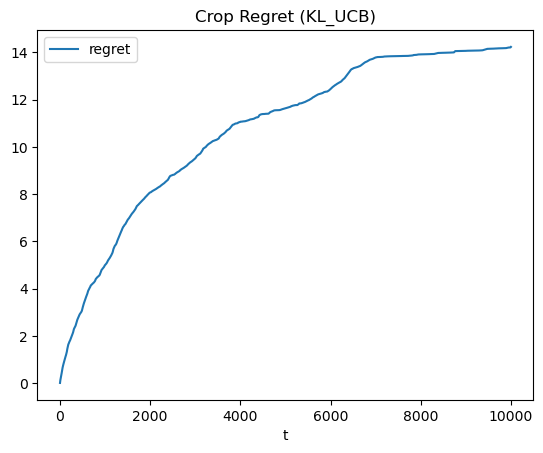

In [69]:
np.random.seed(SEED)
policy = KL_UCB
submission_df = run_repeated_experiments(policy, T, K_CROPS, SEED, CropEnvironment)
submission_df.plot(x = 't', y = 'regret', title = f'Crop Regret ({policy.__name__})')